In [1]:
## Classification of four weather categories in images from dataset

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [3]:
#splitting into train test split, setting batch size 

image_size = (180, 180)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset2",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset2",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1125 files belonging to 4 classes.
Using 900 files for training.
Found 1125 files belonging to 4 classes.
Using 225 files for validation.


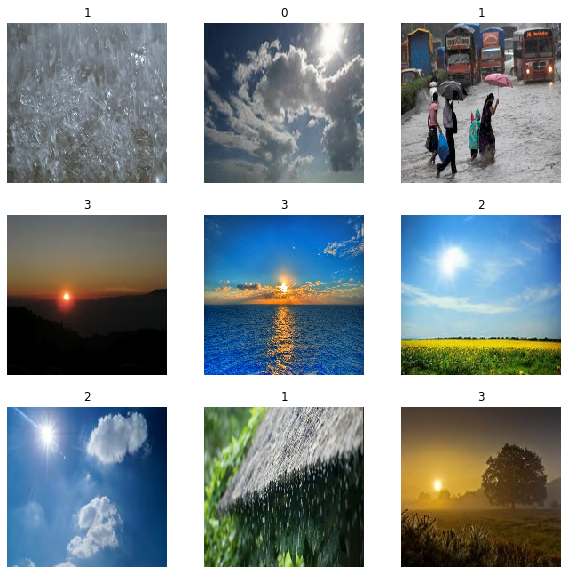

In [4]:
#examining our images/classes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
##Data augmentation to help with our reltively small dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

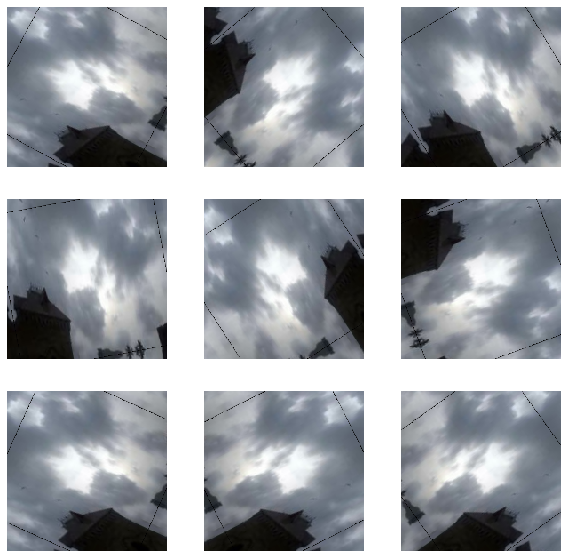

In [6]:
#viewing the transformations

for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [7]:
##Apply transformations to entire training dataset
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/30
57/57 [==============================] - 185s 3s/step - loss: 0.8301 - accuracy: 0.2156 - val_loss: 0.6931 - val_accuracy: 0.1956
Epoch 2/30
57/57 [==============================] - 176s 3s/step - loss: 0.7560 - accuracy: 0.2089 - val_loss: 0.6932 - val_accuracy: 0.1911
Epoch 3/30
57/57 [==============================] - 182s 3s/step - loss: 0.7410 - accuracy: 0.2367 - val_loss: 0.6940 - val_accuracy: 0.2933
Epoch 4/30
57/57 [==============================] - 222s 4s/step - loss: 0.7319 - accuracy: 0.2244 - val_loss: 0.6951 - val_accuracy: 0.2933
Epoch 5/30
57/57 [==============================] - 197s 3s/step - loss: 0.7153 - accuracy: 0.2167 - val_loss: 0.6935 - val_accuracy: 0.2933
Epoch 6/30
57/57 [==============================] - 193s 3s/step - loss: 0.7101 - accuracy: 0.2078 - val_loss: 0.6932 - val_accuracy: 0.1911
Epoch 7/30
57/57 [==============================] - 182s 3s/step - loss: 0.7122 - accuracy: 0.2478 - val_loss: 0.6932 - val_accuracy: 0.2933
Epoch 8/30
57

In [15]:
model2 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation = 'relu', padding = 'same',
                       input_shape = image_size + (3,)),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = 'same'),
    keras.layers.Conv2D(128, 3, activation = "relu", padding = 'same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation = "relu", padding = 'same'),
    keras.layers.Conv2D(256, 3, activation = "relu", padding = 'same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation = 'relu'),
])

In [16]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model2.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model2.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/30
57/57 [==============================] - 292s 5s/step - loss: -0.4179 - accuracy: 0.1956 - val_loss: -7.5907 - val_accuracy: 0.1911
Epoch 2/30
57/57 [==============================] - 336s 6s/step - loss: -1.0262 - accuracy: 0.2122 - val_loss: -7.5907 - val_accuracy: 0.1911
Epoch 3/30
57/57 [==============================] - 327s 6s/step - loss: -0.8484 - accuracy: 0.1956 - val_loss: -7.5907 - val_accuracy: 0.1911
Epoch 4/30
57/57 [==============================] - 303s 5s/step - loss: -0.4258 - accuracy: 0.2089 - val_loss: -7.5907 - val_accuracy: 0.1911
Epoch 5/30
57/57 [==============================] - 331s 6s/step - loss: -0.1651 - accuracy: 0.1856 - val_loss: -7.5907 - val_accuracy: 0.1911
Epoch 6/30
57/57 [==============================] - 254s 4s/step - loss: -0.3148 - accuracy: 0.2044 - val_loss: -7.5907 - val_accuracy: 0.1911
Epoch 7/30
57/57 [==============================] - 244s 4s/step - loss: -0.8509 - accuracy: 0.1900 - val_loss: -7.5907 - val_accuracy: 0.1911

KeyboardInterrupt: 